<a href="https://colab.research.google.com/github/long4coventry/6057CEM/blob/main/Covid_Chest_X_Rays_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

### Declaring the image size and the train, test pat of the dataset

In [2]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [224,224]

train_path = '/content/covid_update/Train'
test_path = '/content/covid_update/Test'

In [13]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"longchen1","key":"c605d570a5917b81113bd5fe216abba8"}'}

In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/    
!ls ~/.kaggle   
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d akhilkasare/covid19-chest-xray-detection

kaggle.json
 95% 129M/136M [00:01<00:00, 91.9MB/s]
100% 136M/136M [00:01<00:00, 94.1MB/s]


In [15]:
!unzip /content/covid19-chest-xray-detection.zip

Archive:  /content/covid19-chest-xray-detection.zip
  inflating: covid_update/Test/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: covid_update/Test/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: covid_update/Test/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: covid_update/Test/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: covid_update/Test/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: covid_update/Test/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: covid_update/Test/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: covid_update/Test/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png  
  inflating: covid_update/Test/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png  
  inflating: covid_update/Test/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2b.png  
  inflating: covid_update/Test/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3a.png  
  inflating

# In this we will be using ResNet-50
* The specialized network was introduced by microsoft
* The ResNet has extremely deep network i.e 152 layers.
* The shallower version (i.e ResNet50) is available

### Why ResNet performs well ?
* Having a regular network which is very deeo actually hurts the performance because of vanishing gradient & exploding gradient.
* In most of the ResNet cases the ResNet will stop improving rather than decreasing the performance.
* If the layer is not useful the L2 Regularization will bring its parameters very close to zero.
* It has moderate efficiency depending on model and has the highest accuracy.
* ResNet allows us to converge more faster


--------------------------------------------------------------------------------

* In `input_shape` argument `+ [3]` basically indicates that there are 3 channels i.e **RGB**.
* The weights we will be using are default weights ie imagent weights.
* The argument `include_top = False` means that in case of ResNet-50 we have **1000 categories** but in our case we have only **two categories**.
* Because of that we dont have to use our 1st and the last layer.
* If you would have had 1000 categories we would have passed `include_top = True`.
* In the top most layer we need to provide our own layer our own dataset beacause of that we are using `include_top = False`.

In [16]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

* Now we dont have to train the existing weights we just have to train our last layer.

In [17]:
for layer in resnet.layers:
  layer.trainable = False

* By using the Glob function we will be able to know our output classes.

In [18]:
folder = glob('/content/covid_update/*')
folder

['/content/covid_update/Test', '/content/covid_update/Train']

* We can clearly see that our dataset have two classes i.e. `covid`, `non-covid`.

### Now the next we need to Flatten our ResNet model.
### What is Flattening of layer, why is it required?

* We need to convert our 2D features to 1D features. Flatting is required when we have to convert our layer to a fully connected layer.

In [19]:
x = Flatten()(resnet.output)

* Adding our last layer

In [20]:
prediction = Dense(len(folder), activation='softmax')(x)

In [21]:
model = Model(inputs = resnet.inputs, outputs = prediction)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

* From the above summary we can see that we have added our first input layer and the last layer with 2 nodes.

### Compiling our model

In [23]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

* Now we need to read all the images from the folder.
* When we'll be reading the data from the folders we also need to make sure that we need to do some **Data Augmentation**.
* The Data Augmentation can be done by using **ImageDataGenerator** library.
* The **ImageDataGenerator** what is does that it applies the Data Augmentation techniques like zooming, scaling, horizontal flipping, vertical flipping, etc.
* **IN THE TEST DATA WE SHOULD NEVER PERFORM DATA AUGMENTATION WE SHOULD ONLY PERFORM SCALING**

In [24]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
# flow_from_directory means i am applying all the train_datagen techniques to all the images
# We need to provide the same traget_size as initialized in the IMAGE_SIZE
# If you have more than two classes we should use class_mode = categorical
# But if we have just two classses we can use class_mode = binary

train_set = train_datagen.flow_from_directory('/content/covid_update/Train',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')

Found 453 images belonging to 2 classes.


In [26]:
# Applying the same techniques on the test dataset

test_set = test_datagen.flow_from_directory('/content/covid_update/Test',
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 219 images belonging to 2 classes.


## Fitting our model

In [27]:
r = model.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

<ipython-input-27-9d5394520b35>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))


Epoch 1/50
15/15 [==============================] - 31s 1s/step - loss: 5.6793 - accuracy: 0.4989 - val_loss: 3.0190 - val_accuracy: 0.4566
Epoch 2/50
15/15 [==============================] - 18s 1s/step - loss: 2.4669 - accuracy: 0.5430 - val_loss: 0.6018 - val_accuracy: 0.7215
Epoch 3/50
15/15 [==============================] - 16s 1s/step - loss: 0.7196 - accuracy: 0.7086 - val_loss: 1.3069 - val_accuracy: 0.5982
Epoch 4/50
15/15 [==============================] - 16s 1s/step - loss: 0.4125 - accuracy: 0.8234 - val_loss: 0.6386 - val_accuracy: 0.7260
Epoch 5/50
15/15 [==============================] - 17s 1s/step - loss: 0.4358 - accuracy: 0.8102 - val_loss: 0.5796 - val_accuracy: 0.7626
Epoch 6/50
15/15 [==============================] - 17s 1s/step - loss: 0.3650 - accuracy: 0.8455 - val_loss: 0.7999 - val_accuracy: 0.7169
Epoch 7/50
15/15 [==============================] - 17s 1s/step - loss: 0.4301 - accuracy: 0.8389 - val_loss: 1.0147 - val_accuracy: 0.6712
Epoch 8/50
15/15 [==

* If your accuracy=100% and your validation accuracy < 50% that means your model is overfitting. 
* validation loss if for the test data

### Plotting the losses and Accuracy on the dataset

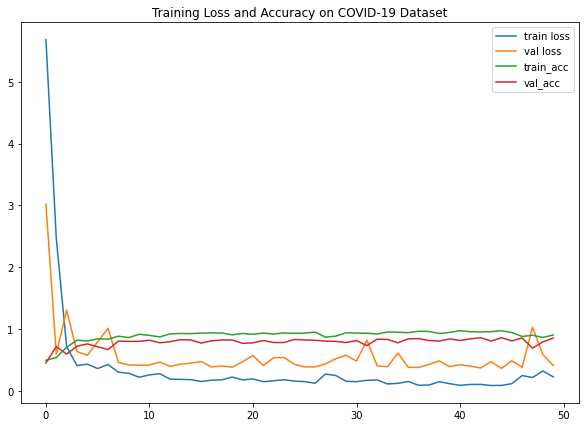

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(10,7))
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.plot(r.history['accuracy'], label='train_acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.legend()
plt.show()
plt.savefig('lossval_loss')

### Saving the h5 file

In [ ]:
from tensorflow.keras.models import load_model

model.save('covid_chest_xray_model.h5')

### Predicting our model

In [ ]:
pred = model.predict(test_set)
pred

array([[9.8186100e-01, 1.8138947e-02],
       [4.9350843e-01, 5.0649154e-01],
       [9.9980921e-01, 1.9081734e-04],
       [9.0678841e-01, 9.3211547e-02],
       [9.9957937e-01, 4.2067567e-04],
       [8.2530469e-01, 1.7469537e-01],
       [9.9219358e-01, 7.8063579e-03],
       [9.9999738e-01, 2.6129997e-06],
       [9.9798310e-01, 2.0169117e-03],
       [9.9984121e-01, 1.5875818e-04],
       [9.9347723e-01, 6.5227593e-03],
       [4.1683774e-02, 9.5831627e-01],
       [9.9933392e-01, 6.6601892e-04],
       [9.9979669e-01, 2.0332613e-04],
       [9.9961334e-01, 3.8665955e-04],
       [9.9973267e-01, 2.6732398e-04],
       [1.7077634e-03, 9.9829227e-01],
       [9.9996781e-01, 3.2225973e-05],
       [9.9997807e-01, 2.1952925e-05],
       [3.5612693e-01, 6.4387310e-01],
       [5.3639442e-01, 4.6360561e-01],
       [8.4792520e-04, 9.9915206e-01],
       [9.9989259e-01, 1.0736020e-04],
       [9.7626865e-01, 2.3731312e-02],
       [8.7633830e-01, 1.2366174e-01],
       [5.6975299e-05, 9.

In [ ]:
import numpy as np

pred = np.argmax(pred, axis=1)
pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

### Loading our model

In [ ]:
model = load_model('covid_chest_xray_model.h5')

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
img = image.load_img('/content/drive/My Drive/covid_update/Test/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg', target_size=(224,224))

In [ ]:
x = image.img_to_array(img)
x

array([[[12., 12., 12.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [14., 14., 14.],
        [14., 14., 14.],
        [12., 12., 12.]],

       [[10., 10., 10.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [15., 15., 15.],
        [14., 14., 14.],
        [15., 15., 15.]],

       [[12., 12., 12.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [15., 15., 15.],
        [15., 15., 15.],
        [15., 15., 15.]],

       ...,

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [20., 20., 20.],
        ...,
        [11., 11., 11.],
        [11., 11., 11.],
        [11., 11., 11.]],

       [[ 1.,  1.,  1.],
        [ 5.,  5.,  5.],
        [20., 20., 20.],
        ...,
        [11., 11., 11.],
        [11., 11., 11.],
        [11., 11., 11.]],

       [[ 1.,  1.,  1.],
        [ 8.,  8.,  8.],
        [18., 18., 18.],
        ...,
        [11., 11., 11.],
        [11., 11., 11.],
        [11., 11., 11.]]

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
x = x/255

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
model.predict(img_data)


array([[1.0000000e+00, 1.3076319e-25]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

In [ ]:
if(a==1):
    print("The person does not have COVID-19")
else:
    print("The person has COVID-19")

The person has COVID-19
